#Energy Consumption under Changing Weather: A Machine Learning Case Study of French Energy Consumption


We implement and evaluate five machine learning models for predicting daily energy consumption in metropolitan France using publicly available weather data. The models range in degrees of interpretability: Linear Regression serves as the baseline model, providing interpretable coefficients for weather features; Decision Trees and Random Forests offer varying levels of transparency through hierarchical decision rules; a Support Vector Machine (SVR) with radial-basis function kernels provide non-linear decision boundaries at the cost of interpretability; and a Multi-Layer Perceptron (MLP) neural network maximizes predictive power through deep hierarchical feature learning, albeit with minimal interpretability.

In [ ]:
# Import of libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import numpy as np
import shap

First, we read in data from our GitHub repository. The data preperation steps are intensive, where the data is pulled from public sources: Consommation Quotidienne Brute Régionale from *Open Data Réseaux Énergies*, Données Climatologiques de Base from *Météo-France*, and Population Municipale des Régions from the *Département de Loiret*. Using the population statistics from the third source, we craft our target value: daily energy consumption per capita.

In [ ]:
# Read-in data
cons_filepath = "https://raw.githubusercontent.com/AnahiRM/Applied_Statistical_Learning/main/data/france_energy_meteo_daily.csv"
energy_source_df = pd.read_csv(cons_filepath)

# Drop NA values from the dataset
energy_source_df.dropna(inplace=True)

# Construction of the target variable
cons_target = "Consumption_per_capita"
target = cons_target

# Ensure the Date column is in a datetime format
energy_source_df["Date"] = pd.to_datetime(energy_source_df["Date"])

# Place consumption data in the correct unit (kWh) and calculate the consumption per capita
energy_source_df["Consumption"] = energy_source_df["Consumption"] * 1000
energy_source_df[cons_target] = energy_source_df["Consumption"] / energy_source_df["population"]


In the following graph, we compare total electricity consumption with consumption per capita over time. The similarity between both series suggests that population has remained relatively stable throughout the study period (2014–2021), and thus is not a major driver of variation. Instead, we observe a strong seasonal pattern in electricity usage, with consistent winter peaks (December–February) and summer troughs (June–August) across all years. These recurring seasonal fluctuations suggest the influence of climate-related factors and support our modeling strategy, which emphasizes weather-based features for forecasting electricity demand.

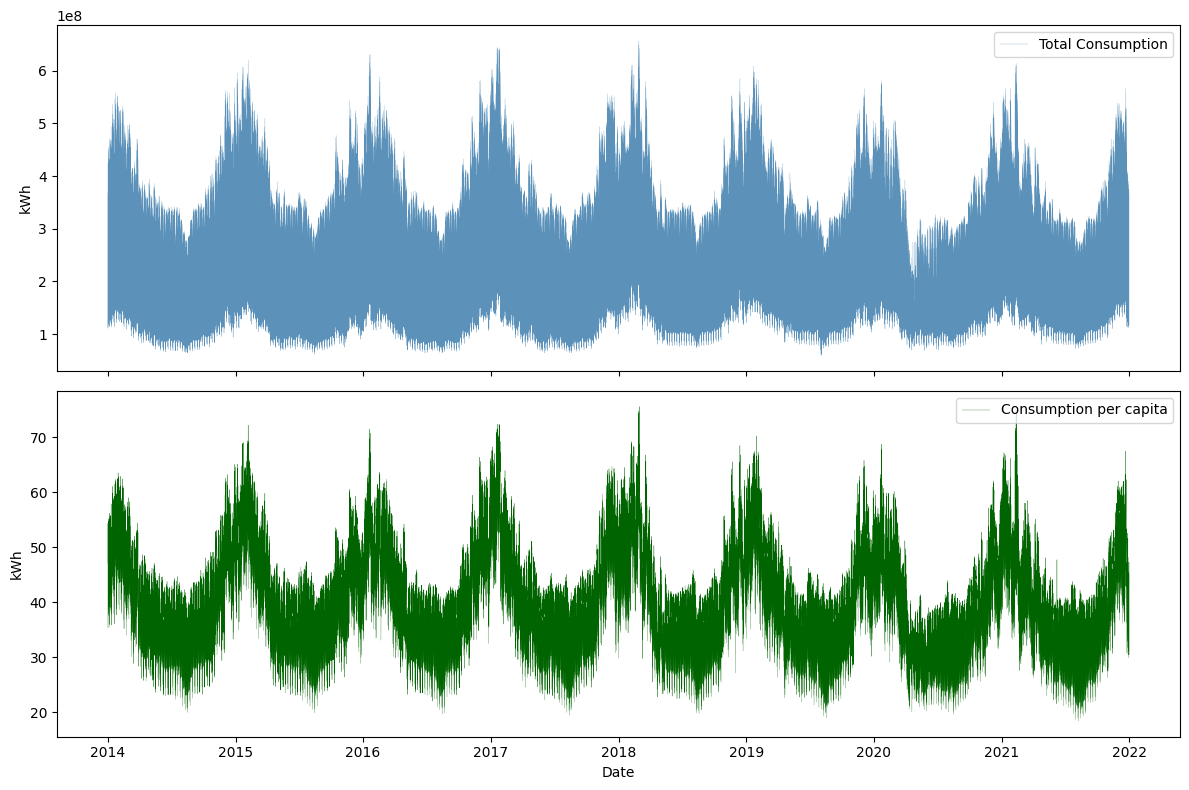

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(energy_source_df['Date'], energy_source_df['Consumption'],
         color='#5c92ba', linewidth=0.2, label='Total Consumption')
ax1.set_ylabel('kWh')
ax1.legend(loc='upper right')
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax2.plot(energy_source_df['Date'], energy_source_df[cons_target],
         color='darkgreen', linewidth=0.2, label='Consumption per capita')
ax2.set_ylabel('kWh')
ax2.set_xlabel('Date')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

After data exploration, we then remove the target variable, and the correlated variables of consumption and population, from the dataset we will use for training. During data preperation, we calculate a variance matrix of all features in the dataset and remove the features with high covariance and keep the feature with stronger covariance with the target variable. We randomly split the data into 80% training and 20% testing data. We define a k-fold cross-validator with five splits, though two splits may be required to run the following models in Colab. Finally, we scale the train and test data for the SVM and Neural Networks to prevent data leakage and vanishing and exploding gradients.

In [ ]:
"""
Create feature and target variables.
Drop categorical variables and highly correlated features
"""
X = energy_source_df.drop(columns=[target, "Date", 'region_name', 'Région',
                                   "Consumption", "population", "superf",
                                   'NEIG', 'SOLNEIGE'])
y = energy_source_df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Define a K-fold cross-validator instead of TimeSeriesSplit
# Due to constraints with CoLab, we recommend lowering the n_splits to 2 if the
# models take too long to run. Though, our results are with the 5 n_splits
# orignally provided.
kfold = KFold(n_splits=2, shuffle=True, random_state=42)

# For models that need scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (23088, 23)
X_test shape: (5772, 23)
y_train shape: (23088,)
y_test shape: (5772,)


For modularity reasons, we build a function to plot the predictions versus the true values of the test data. The resulting graphs provide simple visuals to compare the performance of the five models as well as the linear regression baseline.

In [ ]:
"""
Function that plots the predictions versus the true values of the test data for
consumption per capita target. The model is also defined in input,
to properly differentiate the results and compare between models.
"""
def plot_predictions(y_true, y_pred, model_name='Model', figure_number="Figure One"):
    plt.figure(figsize=(10, 6))

    plt.scatter(y_true, y_pred, alpha=0.6)

    max_val = max(y_true.max(), y_pred.max())
    min_val = min(y_true.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

    plt.title(r"$\bf{" + figure_number + r"}$ — Actual vs Predicted — " + model_name, fontsize=20)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

From here to the end of the code, the implementation of linear regression and our five statistical learning models is executed. These include: (1) Linear Regression, (2) Decision Tree, (3) Random Forest Regressions, (4) Support Vector Machines Regression with a Radial Base Function Kernel, (5) Multi Layer Perceptron Neural Network.


For each model, we compute the mean absolute error, root mean squared error, and r-squared. To complement these numerical metrics, we also present Actual vs. Predicted plots and SHAP (SHapley Additive Explanations) analyses, which help visualize model performance and interpret the contribution of each feature for models that offer good or partial interpretability.



**Mean absolute error** (MAE) calculates the average absolute residuals between the true value and estimate of the target variable, allowing for more comprehensible results. The MAE can be interpreted as the number of kWh per person away from the true result. The closer MAE is to zero, the better the model performs in this metric.

$$ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| $$

**Root mean square error** (RMSE) penalizes large errors by squaring the residuals, but returns the result to the original unit space by rooting the MSE. This metric is particularly important in the energy consumption context, since large underestimates have serious political consequences and over estimates can have stark negative environmental and business consequences. The closer RMSE is to zero, the better the model performs in this metric.

$$ \text{RMSE} = \sqrt{ \frac{\sum (y_i - \hat{y}_i)^2}{n} } $$

Finally, the **r-squared** value measures how much of the variance in the model is explained by the features in the dataset. An r-squared value closer to 1 implies a fully explained model while a value closer to 0 implies that little of the variance is explained by the features.

$$ R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2} $$

We begin with a baseline linear regression model. While inherently less flexible than non-linear alternatives, its architectural simplicity ensures high interpretability, allowing for a direct quantification of how specific weather features influence consumption.


Linear Regression
MAE: 4.409406632514415
RMSE: 5.498679529846738
R-Squared: 0.6773533185697931


<>:17: SyntaxWarning: invalid escape sequence '\ '
<>:17: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-104720682.py:17: SyntaxWarning: invalid escape sequence '\ '
  figure_number='Figure\ One')


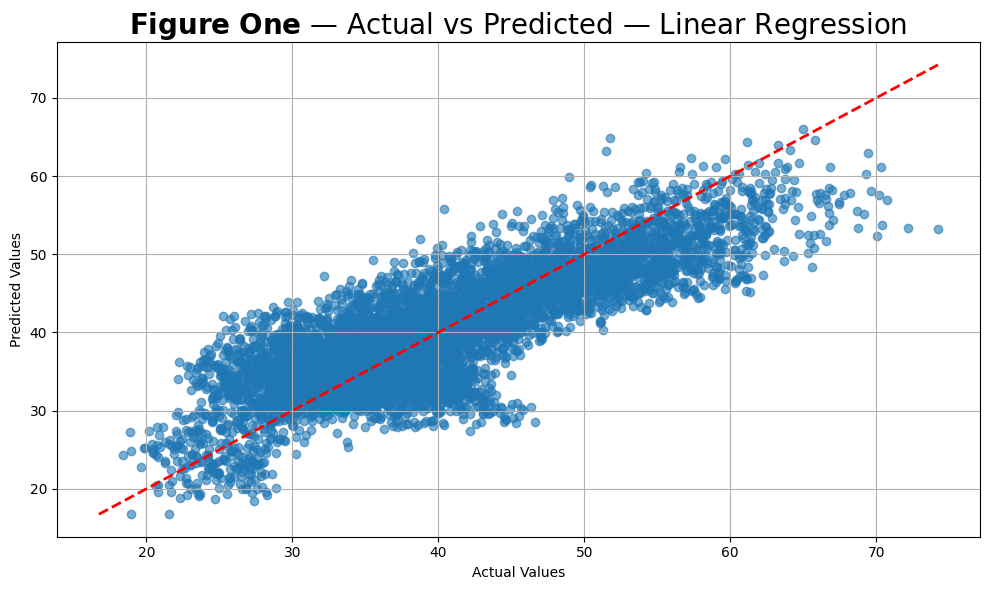

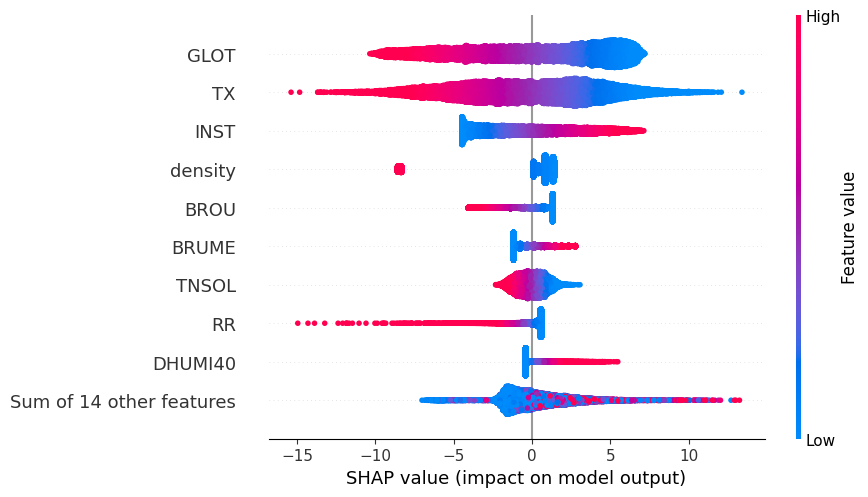

In [ ]:
# (1) Linear Regression
# Generate, Fit, Predict
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Evaluation Metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("\nLinear Regression")
print("MAE:", mae_lr)
print("RMSE:", rmse_lr)
print("R-Squared:", r2_lr)
plot_predictions(y_test, y_pred_lr, model_name='Linear Regression',
                 figure_number='Figure\ One')

# SHAP Explainer
explainer_lr = shap.LinearExplainer(lr_model, X_train)
shap_values_lr = explainer_lr(X_train)
shap.plots.beeswarm(shap_values_lr)

Next, we generate and test a decision tree model. These are more flexible than linear regression models, but still offer interpretability with clear pathways of prediction from root to leaf. We add a visualization of the tree to underscore this point, as a viewer can understand the decision making process by following the structure of the tree downwards.

<>:38: SyntaxWarning: invalid escape sequence '\ '
<>:38: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-265913531.py:38: SyntaxWarning: invalid escape sequence '\ '
  figure_number="Figure\ Two")



Decision Tree Regression:
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 2}
MAE: 3.082128496394478
RMSE: 3.8985500658825263
R-squared: 0.8378127851558059


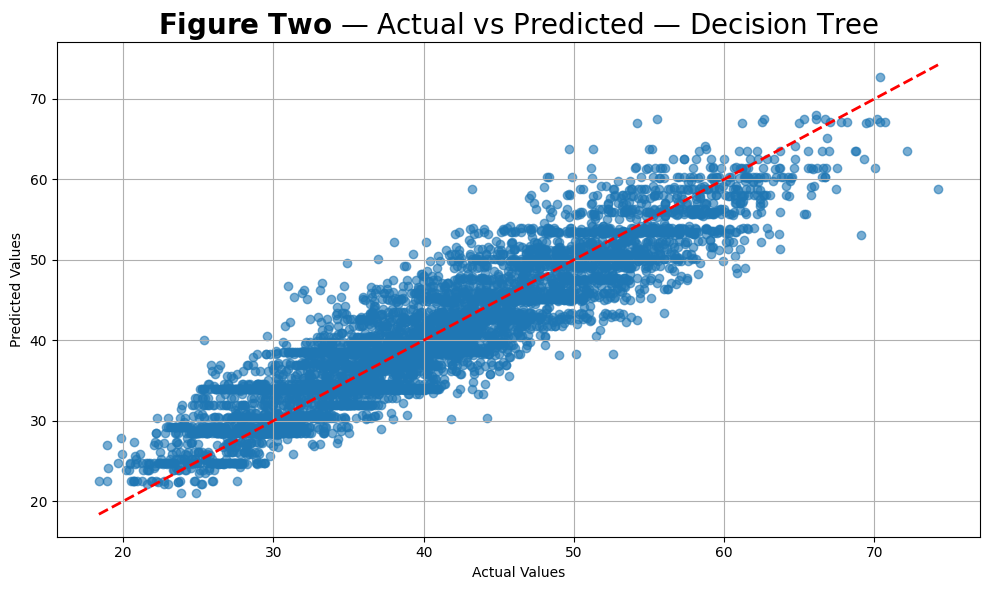

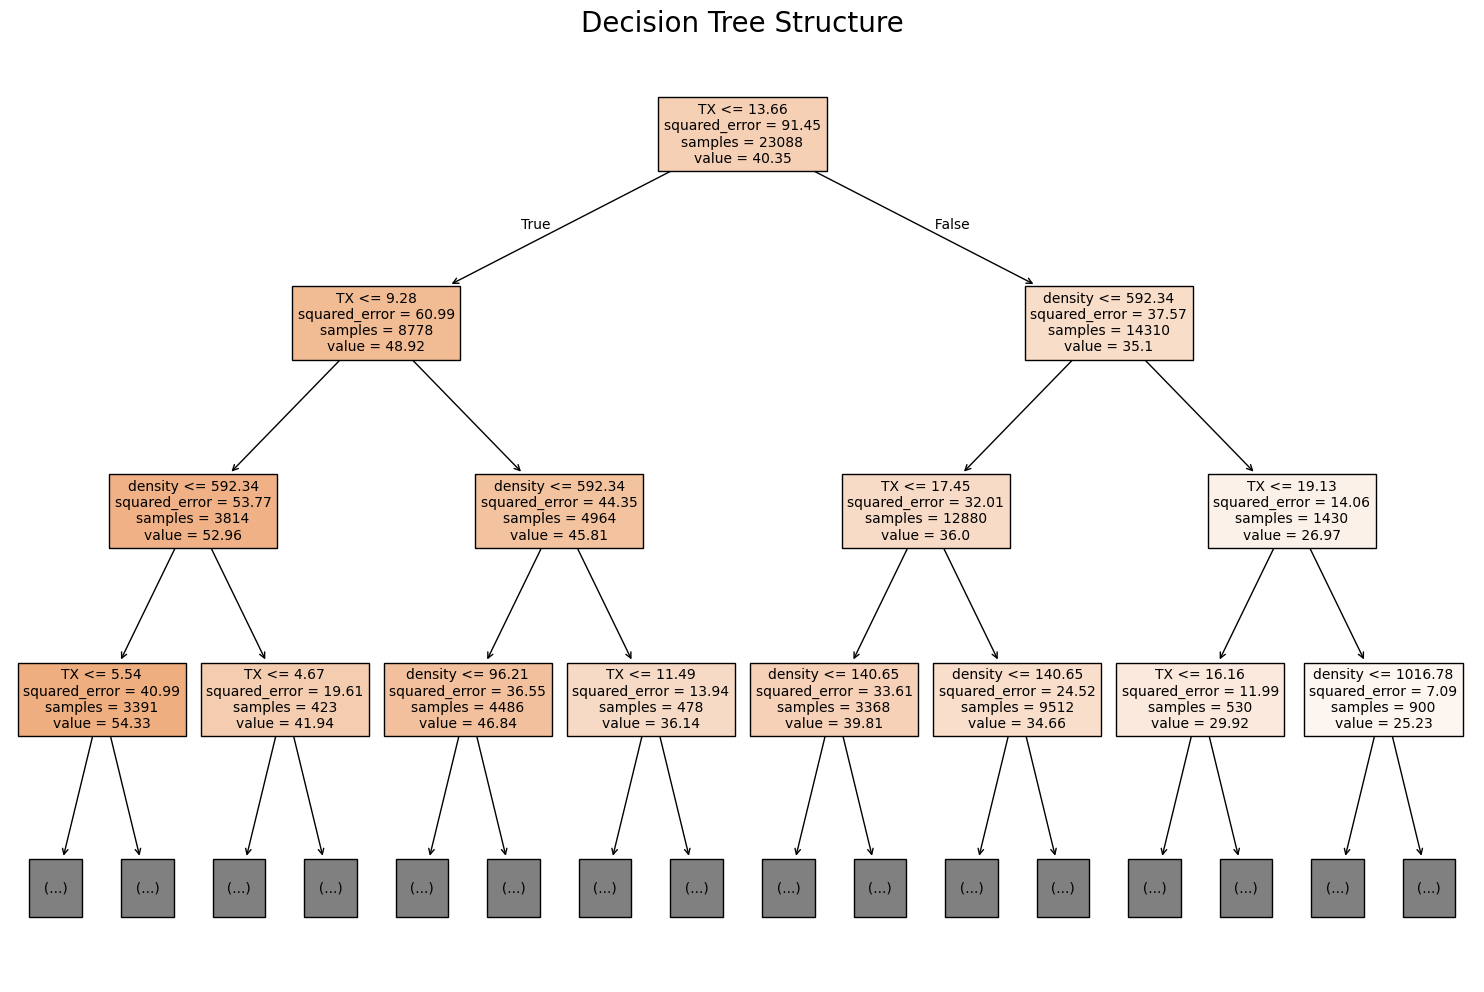

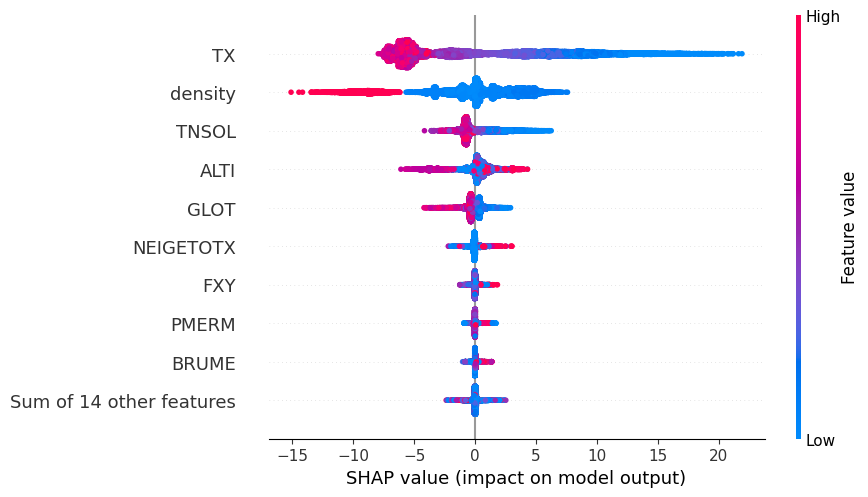

In [ ]:
# (2) Decision Tree

# Perform a GridSearchCV that performs cross validation and
# tuning at the same time. Necessary to
# establish the best performing model for model comparison.
dt_params = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [4, 6, 8]
}

dt_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    dt_params,
    cv=kfold,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Fit training data and cross validate to find best parameters,
# Generate from Best Estimator in GridSearch, Predict
dt_grid.fit(X_train, y_train)
dt_model = dt_grid.best_estimator_
y_pred_dt = dt_model.predict(X_test)


# Evaluation Metrics
mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

print("\nDecision Tree Regression:")
print("Best Parameters:", dt_grid.best_params_)
print("MAE:", mae_dt)
print("RMSE:", rmse_dt)
print("R-squared:", r2_dt)
plot_predictions(y_test, y_pred_dt, model_name='Decision Tree',
                 figure_number="Figure\ Two")

# Print a decision tree to communicate the ease in which a planner
# could explain the prediction from a decision tree.
plt.figure(figsize=(15, 10))
plot_tree(dt_model,
          feature_names=X.columns,
          filled=True,
          proportion=False,
          precision=2,
          impurity=True,
          max_depth=3,
          fontsize=10,
          node_ids=False,)
plt.title(r"Decision Tree Structure", fontsize=20)
plt.tight_layout(pad=1.0)
plt.show()

# SHAP Explainer
explainer_dt = shap.TreeExplainer(dt_model)
shap_values_dt = explainer_dt(X_train)
shap.plots.beeswarm(shap_values_dt)

Third is our Random Forests model. Random Forests average the predictions from many decision trees. This increases the efficacy of the prediction at the expense of the interpretability of the model.

In [ ]:
# (3) Random Forests

# Perform a GridSearchCV that performs cross validation and tuning at the
# same time. Necessary to establish the best performing model
# for model comparison.
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    }

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    cv=kfold,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Fit training data and cross validate to find best parameters,
# Generate from Best Estimator in GridSearch, Predict
rf_grid.fit(X_train, y_train)
rf_model = rf_grid.best_estimator_
y_pred_rf = rf_model.predict(X_test)

# Evaluation Metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Regression:")
print("Best Parameters:", rf_grid.best_params_)
print("MAE:", mae_rf)
print("RMSE:", rmse_rf)
print("R-squared:", r2_rf)
plot_predictions(y_test, y_pred_rf, model_name='Random Forest',
                 figure_number="Figure\ Three")

# SHAP Explainer
explainer_rf = shap.TreeExplainer(rf_model)
X_train_sample = X_train.iloc[np.random.choice(X_train.shape[0], size=500, replace=False)] #size=15000
shap_values_rf = explainer_rf(X_train_sample)
shap.plots.beeswarm(shap_values_rf)

<>:38: SyntaxWarning: invalid escape sequence '\ '
<>:38: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-2231921771.py:38: SyntaxWarning: invalid escape sequence '\ '
  figure_number="Figure\ Three")


Fourth, we construct and fit a SVM with a radiam base function kernel. SVMs with non-linear kernels, such as with a radial-base function, distort the dimensionality of the data, making the factors of a prediction uninterpretable.


In [ ]:
# (4) Support Vector Machines - Radial Base Function

# Perform a GridSearchCV that performs cross validation and tuning
# at the same time. Necessary to establish the best performing model
# for model comparison.
svr_rbf_params = {
    'C': [0.1, 1.0, 10.0, 100.0],#
    'gamma': ['scale','auto', 0.1, 0.01],#,
    'epsilon': [0.1, 0.2, 0.3]#
}

svr_rbf_grid = GridSearchCV(
    SVR(kernel='rbf'),
    svr_rbf_params,
    cv=kfold,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Fit and cross validate with scaled training,
# Generate from Best Estimator in GridSearch,
# Predict to scaled test
svr_rbf_grid.fit(X_train_scaled, y_train)
svr_rbf_model = svr_rbf_grid.best_estimator_
y_pred_svr_rbf = svr_rbf_model.predict(X_test_scaled)

# Evaluation Metrics
mae_svr_rbf = mean_absolute_error(y_test, y_pred_svr_rbf)
rmse_svr_rbf = np.sqrt(mean_squared_error(y_test, y_pred_svr_rbf))
r2_svr_rbf = r2_score(y_test, y_pred_svr_rbf)

print("\nSVR (RBF):")
print("Best Parameters:", svr_rbf_grid.best_params_)
print("MAE:", mae_svr_rbf)
print("RMSE:", rmse_svr_rbf)
print("R-squared:", r2_svr_rbf)
plot_predictions(y_test, y_pred_svr_rbf, model_name='SVR RBF',
                 figure_number="Figure\ Four")

Finally, we create, optimize and test a MLP neural network. Neural networks maximize predictive performance through multiple stacked layers of non-linear transformations, enabling the learning of complex hierarchical feature interactions; however, this exceptional flexibility renders the model fundamentally uninterpretable, as the distributed representations learned across layers cannot be directly mapped to input variables or physical phenomena.

In [ ]:
# (5) Neural Network (MLP)

mlp_params = {
    'hidden_layer_sizes': [(25, 25, 25, 25, 25), (25, 25, 25, 25)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.5, 1.0, 2.0, 5.0],
    'learning_rate_init': [0.0005, 0.001, 0.002, 0.005],
}

mlp_grid = GridSearchCV(
    MLPRegressor(random_state=42, max_iter=1000),
    mlp_params,
    cv=kfold,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

mlp_grid.fit(X_train_scaled, y_train)
mlp_model = mlp_grid.best_estimator_
y_pred_mlp = mlp_model.predict(X_test_scaled)

# Evaluation Metrics
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
r2_mlp = r2_score(y_test, y_pred_mlp)

print("\nNeural Network (MLP):")
print("Best Parameters:", mlp_grid.best_params_)
print("MAE:", mae_mlp)
print("RMSE:", rmse_mlp)
print("R-squared:", r2_mlp)
plot_predictions(y_test, y_pred_mlp, model_name='Neural Network (MLP)',
                 figure_number="Figure\ Five")